#0.Netflix 데이터 분석 개요
- 사용한 데이터 출처: [캐글 넷플릭스 링크](https://www.kaggle.com/datasets/shivamb/netflix-shows)

< 분석 목표>
1) 오징어 게임 검색
2) Movie & TV show 비율 시각화
3) 연도별 Movie & TV show 수치 시각화
4) 월별 Movie & TV show 수치 시각화
5) 나라별 타겟팅하는 연령 시각화
6) 워드클라우들 (핵심 단어 시각화)

# 1.초기 세팅

In [ ]:
# 분석 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns

In [28]:
# 코랩 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# 파일 불러오기
netflix = pd.read_csv("/content/drive/MyDrive/분석/netflix/netflix_titles.csv")

나눔 폰트 설치
  
  !sudo apt-get install -y fonts-nanum
  

  !sudo fc-cache -fv


  !rm ~/.cache/matplotlib -rf

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ① 설치된 나눔고딕 파일 경로 (코랩 기본 위치)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# ② Matplotlib 폰트 매니저에 파일을 직접 등록
fm.fontManager.addfont(font_path)

# ③ 파일에서 실제 폰트 '이름' 가져와 rcParams에 지정
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("사용 중인 폰트:", mpl.rcParams['font.family'])

사용 중인 폰트: ['NanumGothic']


# 2.데이터 내용 확인

In [ ]:
# 1. 데이터 전반적인 정보 확인 (컬럼명, 데이터타입 등)
netflix.info()

In [149]:
# 2. 데이터 상담 5개 행 출력
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_group
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9,Teens
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9,Adults
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Data,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9,Adults
3,s4,TV Show,Jailbirds New Orleans,No Data,No Data,No Data,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,9,Adults
4,s5,TV Show,Kota Factory,No Data,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,9,Adults


In [30]:
# 3. 결측치 비율 확인
# for 반복문을 통해 각 컬럼별 결측치 비율 계산하여 문자열로 출력

for i in netflix.columns :
  missingValueRate = netflix[i].isna().sum() / len(netflix) *100
  if missingValueRate > 0 :
    print("{} null rate : {}%".format(i,round(missingValueRate, 2)))

director null rate : 29.91%
cast null rate : 9.37%
country null rate : 9.44%
date_added null rate : 0.11%
rating null rate : 0.05%
duration null rate : 0.03%


#3.전처리

In [31]:
# 1. 결측치 처리

# (1) 결측치 비율 : country(9.44%), director(29.91%), cast(9.37%)  -> 결측치 No Data로 채우기
netflix['country'] = netflix['country'].fillna('No Data')
netflix['cast']    = netflix['cast'].replace(np.nan, 'No Data')
netflix['director'] = netflix['director'].replace(np.nan, 'No Data')

# (2) 결측치 비율 : date_added(0.11%), rating(0.05%), duration(0.03%) -> 결측치가 있는 행 전체 제거
netflix.dropna(axis = 0, inplace=True)

In [32]:
# 결측치 개수 재확인
netflix.isnull().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,0
date_added,0
release_year,0
rating,0
duration,0


In [33]:
# 2. Feature Engineering1
## 기존에 존재하는 변수를 활용하여 새로운 정보를 추가로 생성
## Netflix의 date_added 변수 -> year_added(개봉한 연도)와 month_added(개봉한 월) 정보를 변수로 생성

# (1) (에러) 공백이 붙어 있어서 pandas가 날짜로 못 읽음 -> 공백 제거 (strip)
netflix['date_added'] = netflix['date_added'].str.strip()


# (2) object 타입 -> datetime타입 변환 (문제가 되는 값 -> 결측치로 바꿔줌)
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')
netflix["date_added"]

,date_added
0,2021-09-25
1,2021-09-24
2,2021-09-24
3,2021-09-24
4,2021-09-24
...,...
8802,2019-11-20
8803,2019-07-01
8804,2019-11-01
8805,2020-01-11


In [34]:
# +) 문제가 된 값 확인해보기
netflix[pd.to_datetime(netflix['date_added'], errors='coerce').isna()]['date_added'].unique()

<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]

In [35]:
# (2) 개봉 연도, 월 정보 추출 -> 저장
netflix['year_added'] = netflix['date_added'].dt.year
netflix['month_added'] = netflix['date_added'].dt.month

netflix.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Data,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9


In [36]:
# 2. Feature Engineering2


## Netflix의 rating 변수를 이용한 age_group(시청 등급) 정보를 변수로 생성 [시청등급표 참고] (https://www.primevideo.com/help/ref=atv_hp_nd_cnt?nodeId=GFGQU3WYEG6FSJFJ)

# rating 변수의 값 파악
netflix['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

In [37]:
netflix['age_group'] = netflix['rating']

age_group = {'TV-MA': 'Adults',
            'R': 'Adults',
            'PG-13': 'Teens',
            'TV-14': 'Young Adults',
            'TV-PG': 'Older Kids',
            'NR': 'Adults',
            'TV-G': 'Kids',
            'TV-Y': 'Kids',
            'TV-Y7': 'Older Kids',
            'PG': 'Older Kids',
            'G': 'Kids',
            'NC-17': 'Adults',
            'TV-Y7-FV': 'Older Kids',
            'UR': 'Adults'}

netflix['age_group'] = netflix['age_group'].map(age_group)

netflix.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_group
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9,Teens
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9,Adults
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Data,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9,Adults


#4.Squid Game (오징어게임) 검색

In [38]:
 # squid game이 포함된 문자열 제목 검색
 # NA일 경우 ->False로 처리 / 대소문자 구분X

netflix[netflix["title"].str.contains('Squid Game', na = False, case = False)]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,age_group
33,s34,TV Show,Squid Game,No Data,"Lee Jung-jae, Park Hae-soo, Wi Ha-jun, Oh Youn...",No Data,2021-09-17,2021,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Thrillers",Hundreds of cash-strapped players accept a str...,2021,9,Adults


#5.Netflix Movie & TV show 비율 시각화

In [39]:
# Movies & TV shows의 각각 value_counts T(전치) 확인
pd.DataFrame(netflix['type'].value_counts()).T

type,Movie,TV Show
count,6126,2664


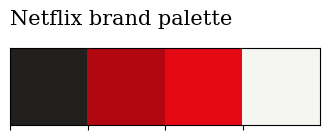

In [40]:
# @title
# 넷플릭스 브랜드 상징 색깔 시각화
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ", loc='left', fontfamily='serif', fontsize=15, y=1.2)
plt.show()

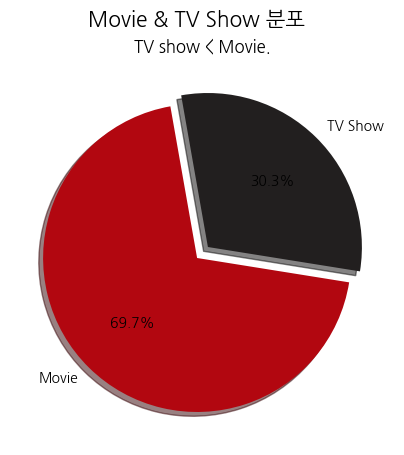

In [46]:
# 1. type별 개수 세기 (Series 1D로 유지)
ratio = netflix['type'].value_counts()

# 2. 파이차트 그리기
plt.figure(figsize=(5, 5))
plt.pie(
    ratio, labels=ratio.index, autopct='%0.1f%%',
    startangle=100, explode=[0.05, 0.05],
    shadow=True, colors=['#b20710', '#221f1f']
)

plt.suptitle("Movie & TV Show 분포", fontsize=15, fontweight='bold')
plt.title("TV show < Movie", fontsize=12)

plt.show()

#6.연도별 Movie & TV show 수치 시각화

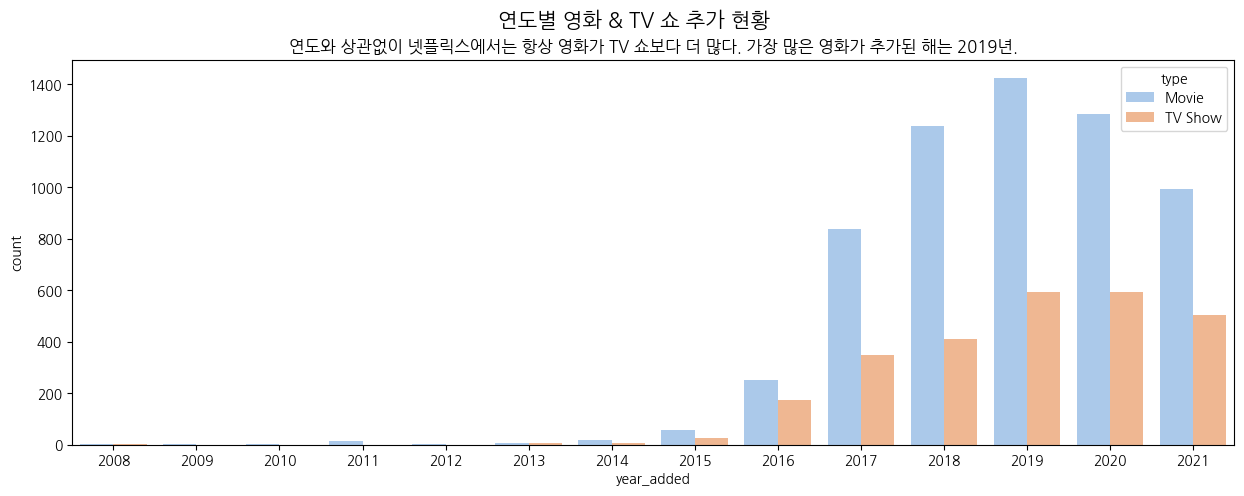

In [48]:
# 항상 movie 가 tv show보다 압도적인지 궁금

plt.figure(figsize=(15, 5))

sns.countplot(data=netflix, x='year_added', hue='type', palette='pastel')
plt.suptitle('Movie & TV Show 현황',fontsize=15,fontweight='bold')
plt.title('항상 영화가 TV 쇼보다 더 많다. 가장 많은 영화가 추가된 해는 2019년.',fontsize=12)

plt.show()

#7.월별 Movie & TV show 수치 시각화

In [49]:
netflix_month = netflix.groupby('month_added')['type'].value_counts().unstack()
netflix_month

type,Movie,TV Show
month_added,,
1,545,192
2,382,180
3,528,213
4,549,214
5,439,193
6,492,236
7,565,262
8,518,236
9,518,251


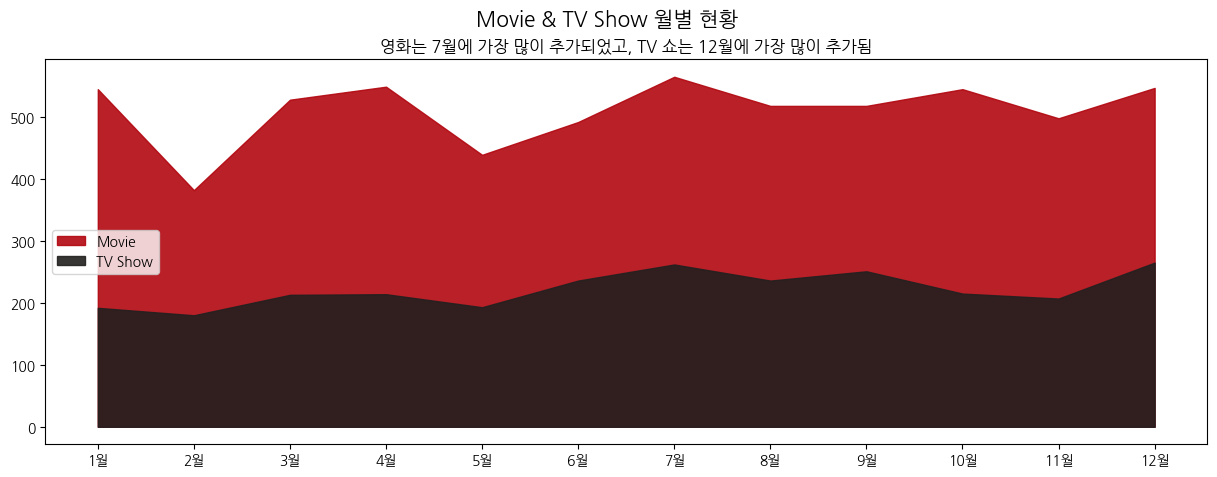

In [51]:
plt.figure(figsize=(15, 5))

plt.fill_between(x=netflix_month['Movie'].index, y1=0, y2=netflix_month['Movie'], color='#b20710', alpha=0.9, label = 'Movie')
plt.fill_between(x=netflix_month['TV Show'].index, y1=0, y2=netflix_month['TV Show'], color='#221f1f', alpha=0.9, label = 'TV Show')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])

plt.legend()

plt.suptitle('Movie & TV Show 월별 현황', fontsize=15, fontweight='bold')
plt.title('영화는 7월에 가장 많이 추가되었고, TV 쇼는 12월에 가장 많이 추가됨',fontsize=12)

plt.show()

#8.국가별 추이

In [140]:
# 국가-연도별 작품 수 집계
country_year_counts = (
    netflix[['show_id', 'country', 'year_added']]
    .dropna(subset=['country', 'year_added'])      # 국가/연도 결측치 제거
    .assign(country=lambda d: d['country'].str.split(','))  # 공동제작 여러 국가 분리
    .explode('country')
    .assign(country=lambda d: d['country'].str.strip())     # 공백 제거
    .query("country != 'No Data'")                         # No Data 제거
    .groupby(['year_added', 'country'])['show_id']
    .nunique()
    .reset_index(name='count'))

In [141]:
# @title
# 전체 기간 동안 작품 수 상위 N개 국가만 선택
TOP_COUNTRIES = 10
top_countries = (
    country_year_counts.groupby('country')['count'].sum()
    .sort_values(ascending=False)
    .head(TOP_COUNTRIES).index
)
country_year_top = country_year_counts[country_year_counts['country'].isin(top_countries)]

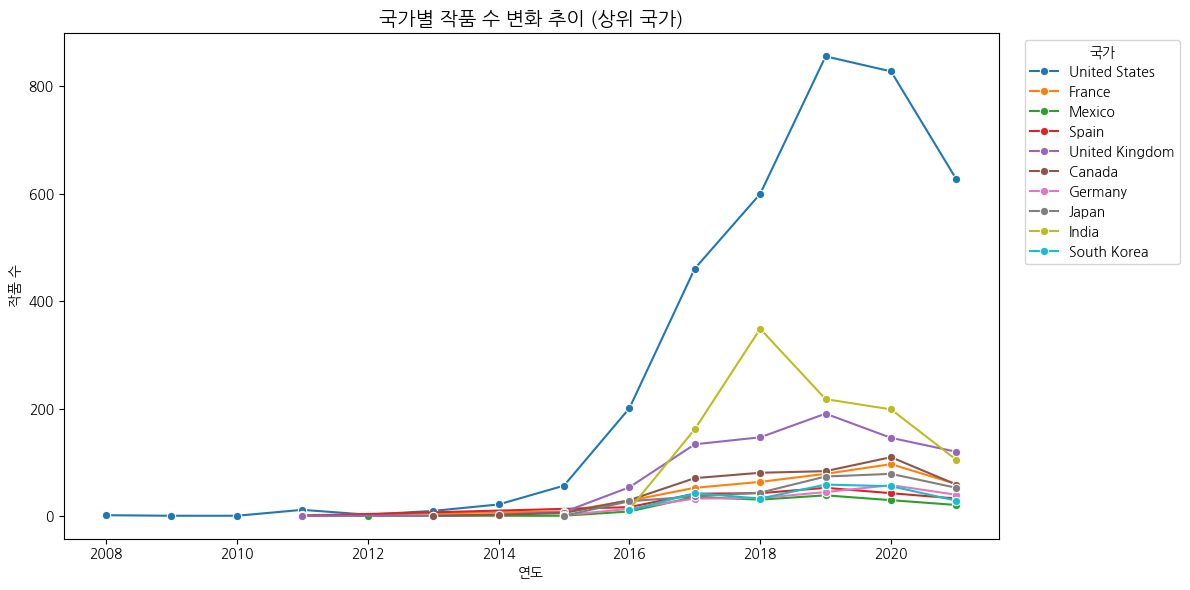

In [142]:
# @title
# 시각화
plt.figure(figsize=(12,6))
sns.lineplot(data=country_year_top, x='year_added', y='count',
             hue='country', marker='o')

plt.title('국가별 작품 수 변화 추이 (상위 국가)', fontsize=14, fontweight='bold')
plt.xlabel('연도'); plt.ylabel('작품 수')
plt.legend(title='국가', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()

In [166]:
# 미국 제외한 국가별 연도별 작품 수 집계 (2015년 이후만)
country_year_no_us = country_year_counts.query("country != 'United States' and year_added >= 2015")

# 상위 10개 국가만 선택
TOP_COUNTRIES_NO_US = 10
top_countries_no_us = (
    country_year_no_us.groupby('country')['count'].sum()
    .sort_values(ascending=False)
    .head(TOP_COUNTRIES_NO_US).index
)

# 상위 국가 데이터만 필터링
country_year_top_no_us = country_year_no_us[
    country_year_no_us['country'].isin(top_countries_no_us)
]

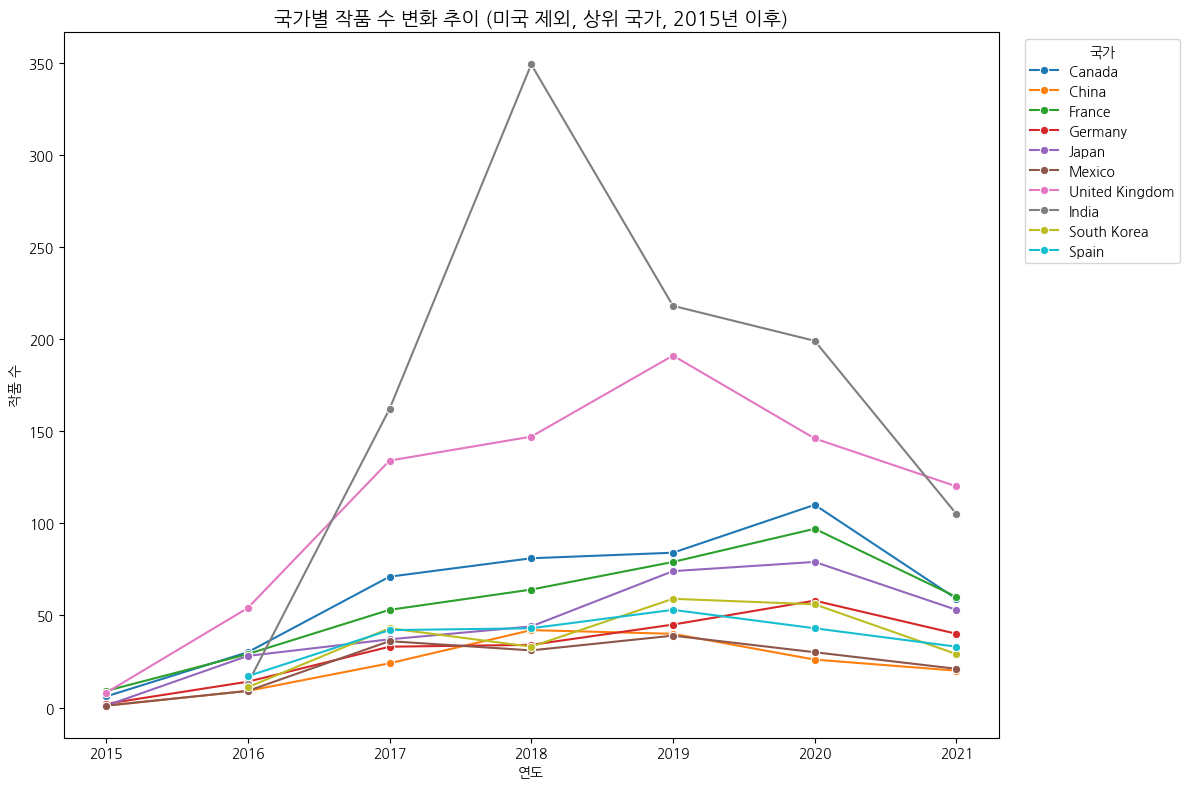

In [167]:
# 시각화
plt.figure(figsize=(12,8))
sns.lineplot(data=country_year_top_no_us, x='year_added', y='count',
             hue='country', marker='o')

plt.title('국가별 작품 수 변화 추이 (미국 제외, 상위 국가, 2015년 이후)', fontsize=14, fontweight='bold')
plt.xlabel('연도'); plt.ylabel('작품 수')
plt.legend(title='국가', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

- 단일 국가 지배 → 미국은 글로벌 콘텐츠 공급의 절대적 중심.

- 신흥 강자 → 인도, 한국, 일본이 2016년 이후 눈에 띄게 부상.

- 지역적 확산 → 유럽(영국, 프랑스, 독일, 스페인)과 아시아(한국, 일본, 인도)가 글로벌 콘텐츠 다양성 확대에 기여.

해석 포인트:

2016년 이후 글로벌 오리지널 전략 → 다양한 국가에서 제작 급증.

코로나 전후(2019~2020년)에는 급증 후 감소 → OTT 시장 경쟁, 제작 환경 변화 반영.

In [157]:
base = (
    netflix[['show_id', 'year_added', 'listed_in', 'country']]
    .dropna(subset=['year_added', 'listed_in'])
    .assign(
        genre=lambda d: d['listed_in'].str.split(','),
        country=lambda d: d['country'].fillna('No Data').str.split(',')  # 여러 나라일 수 있음
    )
    .explode('genre')
    .explode('country')
    .assign(
        genre=lambda d: d['genre'].str.strip(),
        country=lambda d: d['country'].str.strip()
    )
    .replace({'country': {'No Data': None}})
    .dropna(subset=['country'])                # 국가 없는 행 제거
)

# 분석 대상 국가(인도, 프랑스,일본, 한국 4개로 정함)
focus_countries = ['India', 'France', 'Japan', 'South Korea']

# 2015년 이후 + 관심 국가만 남기기
base_2015 = base.query("year_added >= 2015 and country in @focus_countries")

In [159]:
# ① (연도-국가-장르)별 '작품 수'
by_ycg = (
    base_2015.groupby(['year_added', 'country', 'genre'])['show_id']
    .nunique()
    .reset_index(name='count')
)

# ② (연도-국가)별 '전체 작품 수'
by_yc_total = (
    base_2015.groupby(['year_added', 'country'])['show_id']
    .nunique()
    .reset_index(name='total')
)

# ③ 비율(%) 계산 = count / total * 100
ycg_ratio = (
    by_ycg.merge(by_yc_total, on=['year_added', 'country'], how='left')
    .assign(ratio=lambda d: d['count'] / d['total'] * 100)
)

# ④ 나라별 상위 5개 장르만 선택 (2015~전체 합 기준)
top5_per_country = (
    by_ycg.groupby(['country', 'genre'])['count'].sum().reset_index()
    .sort_values(['country', 'count'], ascending=[True, False])
    .groupby('country')
    .head(5)
)

# 필터링: 나라-장르가 top5에 해당하는 것만 남기기
mask = ycg_ratio.set_index(['country', 'genre']).index.isin(
    top5_per_country.set_index(['country', 'genre']).index
)
ycg_ratio_top5 = ycg_ratio[mask]

<Figure size 1400x1000 with 0 Axes>

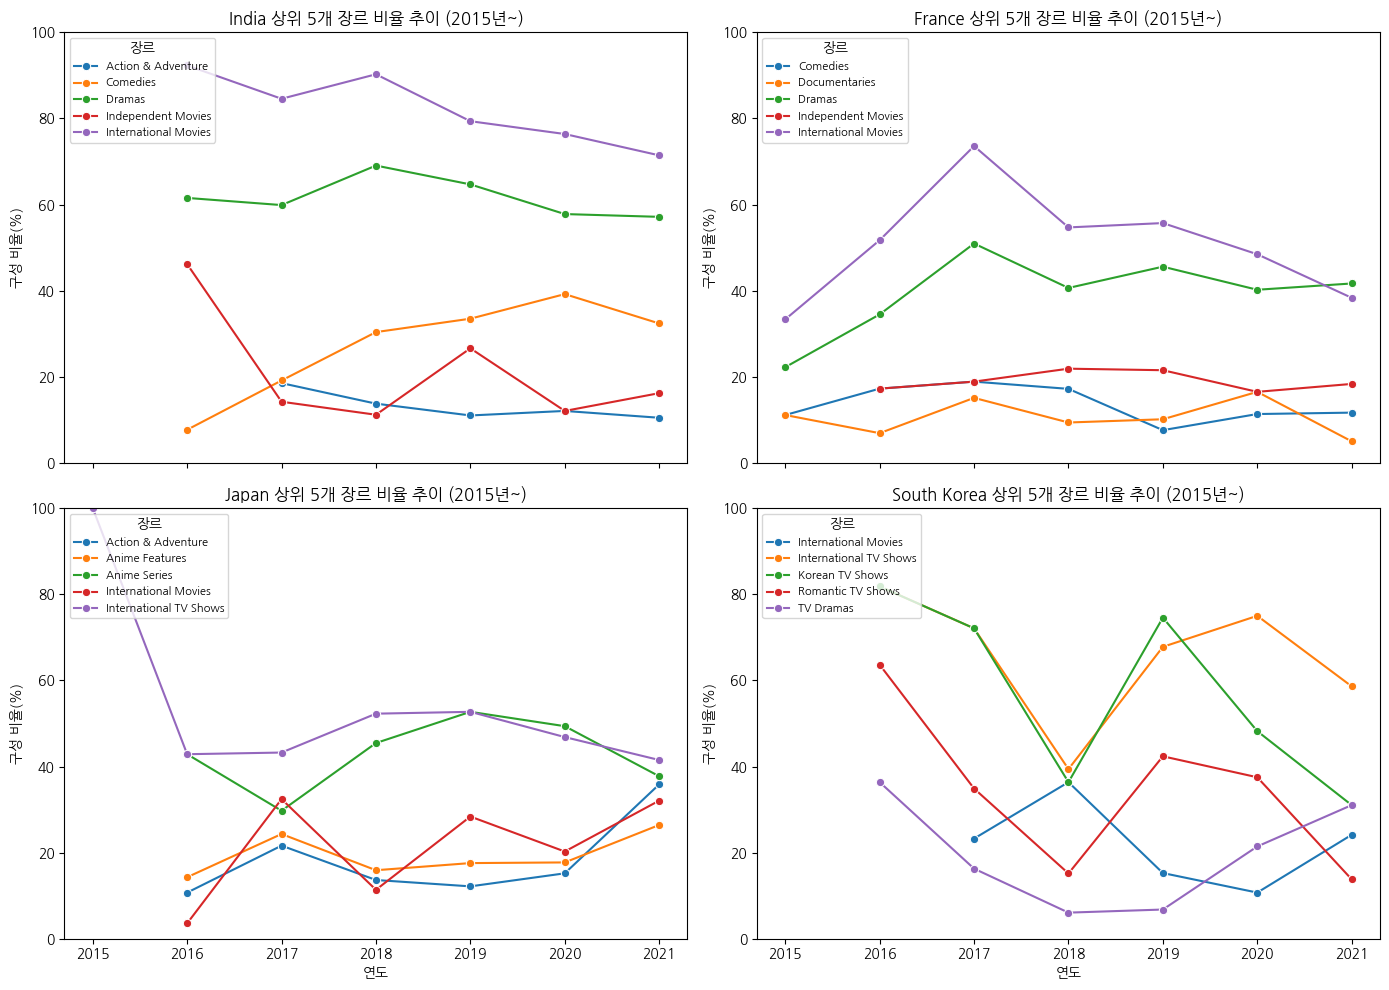

In [161]:
# 시각화: 4분할 subplot

plt.figure(figsize=(14, 10))
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
axes = axes.flatten()

for i, c in enumerate(focus_countries):
    ax = axes[i]
    data_c = ycg_ratio_top5.query("country == @c").sort_values(['genre', 'year_added'])

    sns.lineplot(
        data=data_c, x='year_added', y='ratio',
        hue='genre', marker='o', ax=ax
    )
    ax.set_title(f"{c} 상위 5개 장르 비율 추이 (2015년~)", fontsize=12, fontweight='bold')
    ax.set_xlabel("연도"); ax.set_ylabel("구성 비율(%)")
    ax.set_ylim(0, 100)                 # 비율 그래프이므로 0~100%
    ax.legend(title='장르', fontsize=8, loc='upper left', ncol=1)

plt.tight_layout()
plt.show()

- 인도(India): International Movies 비중이 높고(80%내외 유지)
  - 2020~2021에는 살짝 하락, 대신 Dramas와 Comedies가 점진적으로 늘어남.

- 프랑스(France):한두 개 장르 쏠림 없이 균형 잡힘.

- 일본(Japan):Anime Features + Anime Series의 합이 50% 이상 유지 → 명확히 애니메이션 주도 시장.

- 한국(South Korea): TV Dramas와 Korean TV Shows가 주요 장르.
  - 특히 2018~2020 사이 TV Dramas 비중이 크게 상승 → 넷플릭스 K-드라마 붐과 일치.
  - International Movies는 꾸준히 낮은 비중.

#9.국가별 타겟팅하는 연령 시각화

In [53]:
# 국가별 타겟팅하는 연령 수치화
netflix_age_country = netflix.groupby('age_group')['country'].value_counts().unstack()
netflix_age_country

country,", France, Algeria",", South Korea",Argentina,"Argentina, Brazil, France, Poland, Germany, Denmark","Argentina, Chile","Argentina, Chile, Peru","Argentina, France","Argentina, France, United States, Germany, Qatar","Argentina, Italy","Argentina, Spain",...,"Uruguay, Argentina, Germany, Spain","Uruguay, Argentina, Spain","Uruguay, Germany","Uruguay, Guatemala","Uruguay, Spain, Mexico",Venezuela,"Venezuela, Colombia",Vietnam,West Germany,Zimbabwe
age_group,,,,,,,,,,,,,,,,,,,,,
Adults,NaN,1.0,42.0,NaN,1.0,1.0,1.0,1.0,1.0,7.0,...,1.0,1.0,NaN,NaN,1.0,NaN,1.0,3.0,1.0,NaN
Kids,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0
Older Kids,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Teens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Young Adults,1.0,NaN,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN


In [54]:
# 특정 국가별 타겟팅하는 특정 연령 선택하여 수치화 / 결측값 0으로 대체

age_order = ['Kids','Older Kids','Teens','Adults']
country_order = ['United States', 'India', 'United Kingdom', 'Canada', 'Japan','France', 'South Korea', 'Spain', 'Mexico', 'Turkey']

netflix_age_country = netflix_age_country.loc[age_order, country_order]

netflix_age_country.fillna(0, inplace = True)
netflix_age_country

country,United States,India,United Kingdom,Canada,Japan,France,South Korea,Spain,Mexico,Turkey
age_group,,,,,,,,,,
Kids,198.0,14.0,42.0,32.0,3.0,12.0,5.0,3.0,2.0,1.0
Older Kids,515.0,151.0,82.0,40.0,60.0,7.0,23.0,6.0,9.0,9.0
Teens,289.0,4.0,8.0,3.0,3.0,1.0,0.0,1.0,1.0,0.0
Adults,1403.0,253.0,214.0,80.0,87.0,83.0,88.0,122.0,85.0,64.0


In [55]:
# 국가별 타겟팅하는 연령별 비율
netflix_age_country = netflix_age_country.div(netflix_age_country.sum(axis=0), axis=1)
netflix_age_country

country,United States,India,United Kingdom,Canada,Japan,France,South Korea,Spain,Mexico,Turkey
age_group,,,,,,,,,,
Kids,0.082328,0.033175,0.121387,0.206452,0.019608,0.116505,0.043103,0.022727,0.020619,0.013514
Older Kids,0.214137,0.357820,0.236994,0.258065,0.392157,0.067961,0.198276,0.045455,0.092784,0.121622
Teens,0.120166,0.009479,0.023121,0.019355,0.019608,0.009709,0.000000,0.007576,0.010309,0.000000
Adults,0.583368,0.599526,0.618497,0.516129,0.568627,0.805825,0.758621,0.924242,0.876289,0.864865


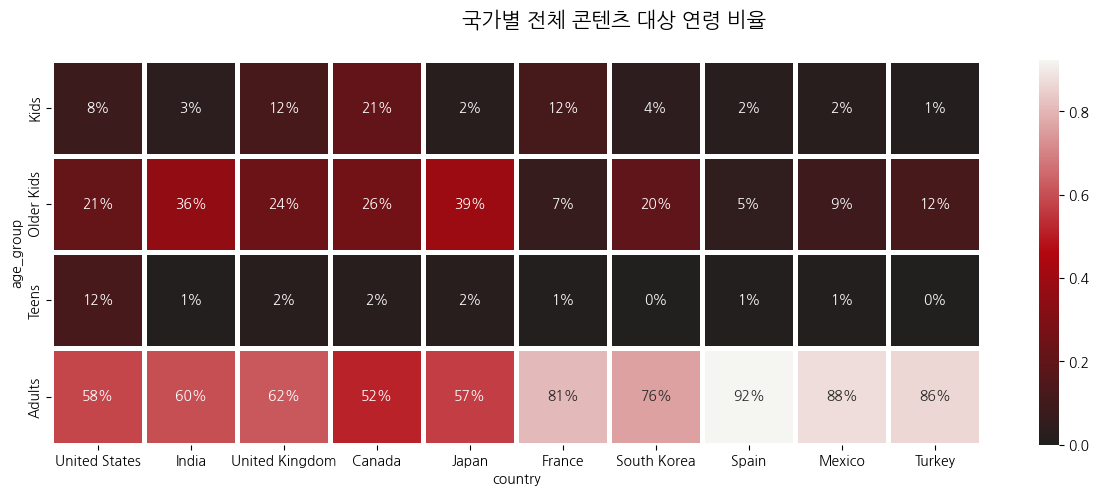

In [56]:
# 국가별 타겟팅하는 연령 시각화 -> heatmap 사용
plt.figure(figsize=(15, 5))

cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])
sns.heatmap(netflix_age_country, cmap = cmap, linewidth=2.5, annot=True, fmt='.0%')
plt.suptitle('국가별 전체 콘텐츠 대상 연령 비율', fontweight='bold',fontsize=15)
plt.show()

1. 전반적으로 성인 대상이 넷플릭스 주요 시장의 주력 타겟임.
2. Older Kids(청소년용) 비율이 눈에 띄는 나라
 - 인도(36%), 일본(39%), 캐나다(26%) → 다른 나라에 비해 상대적으로 청소년 타겟이 많음.
- 특히 일본은 애니메이션 영향으로 청소년 타겟 비중이 높은 걸로 해석 가능함.
3. Kids(아동용)·Teens(청소년기 초반) 비율은 전체적으로 낮음
- 미국: Kids 8%, Teens 12%


#10.국가별 특화 장르 비교

In [70]:
# 분석에 필요한 열(show_id, country, listed_in)만 뽑아오기
netflix_country_genre = netflix[['show_id','country','listed_in']]

# country나 genre가 비어 있으면 분석 불가 → 결측치 제거
netflix_country_genre = netflix_country_genre.dropna(subset=['country','listed_in'])

# 'No Data' 같은 값도 결측치로 처리 후 제거
netflix_country_genre['country'] = netflix_country_genre['country'].replace('No Data', np.nan)
netflix_country_genre = netflix_country_genre.dropna(subset=['country'])

In [71]:
# 한 작품이 여러 나라/여러 장르에 속할 수 있음 → 쉼표(,)로 구분되어 있음
# explode를 사용해 행을 여러 개로 나누고, strip으로 앞뒤 공백 제거

netflix_country_genre = netflix_country_genre.assign(country=netflix_country_genre['country'].str.split(',')).explode('country')
netflix_country_genre = netflix_country_genre.assign(genre=netflix_country_genre['listed_in'].str.split(',')).explode('genre')

netflix_country_genre['country'] = netflix_country_genre['country'].str.strip()
netflix_country_genre['genre']   = netflix_country_genre['genre'].str.strip()

In [73]:
# 혹시 같은 작품이 같은 나라/장르에 중복 기록될 수 있으니 안전하게 중복 제거
netflix_country_genre = netflix_country_genre.drop_duplicates(['show_id','country','genre'])

In [74]:
# 국가별로 장르 개수 집계 (교차표: 국가 × 장르 테이블 생성)
country_genre_crosstab = pd.crosstab(netflix_country_genre['country'], netflix_country_genre['genre'])

In [76]:
# 상위 10개 국가, 상위 12개 장르만 선택 (너무 많으면 시각화가 복잡-> 상위만 추출) [국가,장르 상위 이름목록만 가져오는 작업]
top_countries = country_genre_crosstab.sum(axis=1).sort_values(ascending=False).head(10).index
top_genres    = country_genre_crosstab.sum(axis=0).sort_values(ascending=False).head(12).index

# 실제 데이터에서 상위 국가/장르에 해당하는 행만 필터링
country_genre_filtered = netflix_country_genre[
    netflix_country_genre['country'].isin(top_countries) &
    netflix_country_genre['genre'].isin(top_genres)]

In [77]:
# 필터링된 데이터로 다시 국가 × 장르 교차표 생성 후 → 국가별 비율(%)로 변환
country_genre_matrix = pd.crosstab(country_genre_filtered['country'], country_genre_filtered['genre'])
country_genre_ratio  = country_genre_matrix.div(country_genre_matrix.sum(axis=1), axis=0) * 100
country_genre_ratio  = country_genre_ratio.loc[top_countries, top_genres]  # 보기 좋게 정렬

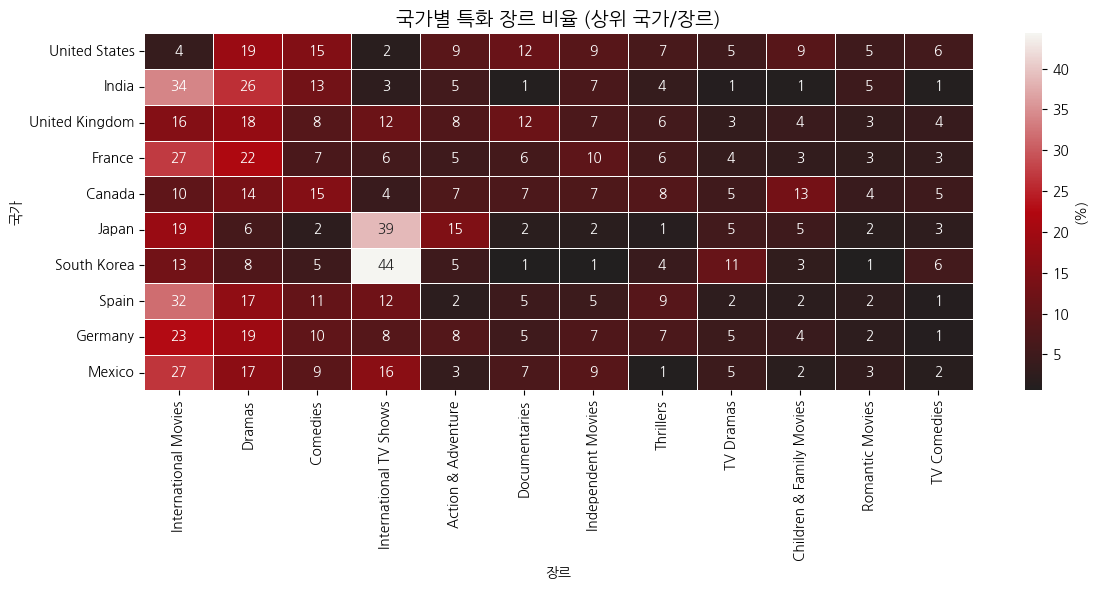

In [86]:
# 히트맵으로 국가별 특화 장르 비율 시각화
plt.figure(figsize=(12,6))

cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])
sns.heatmap(country_genre_ratio, cmap= cmap, annot=True, fmt='.0f', linewidths=.5, cbar_kws={'label':'(%)'})
plt.title('국가별 특화 장르 비율 (상위 국가/장르)', fontsize=14, fontweight='bold')
plt.xlabel('장르'); plt.ylabel('국가')
plt.tight_layout(); plt.show()

- India (인도) : Dramas(26%), International Movies(34%) → 인도는 드라마 + 국제 영화에 강하게 특화.

- Japan (일본) : International TV Shows(39%) → 일본은 국제 TV 쇼 장르 비율이 압도적으로 높음.
- South Korea (한국) : International TV Shows(44%) → 한국도 일본과 비슷하게 국제 TV 쇼가 두드러짐.

- France / Spain / Mexico : International Movies + Dramas 비율이 높은 편 → 전통적 영화 중심.

- United States (미국) : International Movies, Dramas, Comedies가 고르게 분포 → 특정 장르 치우침이 적고 다양성이 특징.

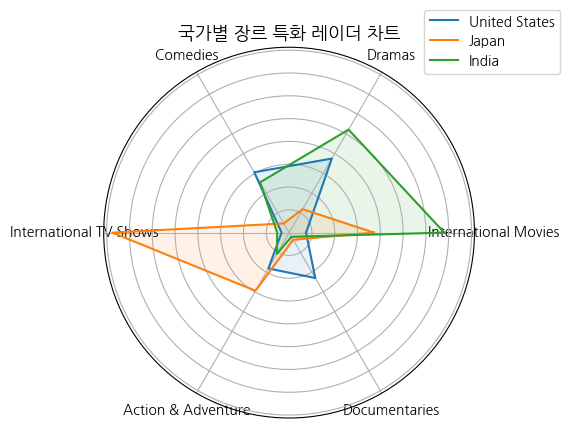

In [80]:
# +) 레이더 차트: 특정 국가 몇 개만 골라 장르 비율 비교
selected_countries = ['United States','Japan','India']   # 비교할 국가 3개
selected_genres    = list(top_genres[:6])                # 대표 장르 6개만 선택 (많으면 복잡)

angles = np.linspace(0, 2*np.pi, len(selected_genres), endpoint=False).tolist(); angles += angles[:1]
plt.figure(figsize=(6,6)); ax = plt.subplot(111, polar=True)

for c in selected_countries:
    vals = country_genre_ratio.reindex(index=selected_countries, columns=selected_genres).loc[c].fillna(0).tolist()
    vals += vals[:1]
    ax.plot(angles, vals, label=c); ax.fill(angles, vals, alpha=0.1)

ax.set_xticks(angles[:-1]); ax.set_xticklabels(selected_genres); ax.set_yticklabels([])
plt.title('국가별 장르 특화 레이더 차트', fontsize=13, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.12))
plt.tight_layout(); plt.show()

- 미국(파랑) : 전체적으로 고른 분포 → 장르 다양성이 가장 두드러짐.

- 일본(주황) : 국제 TV Shows가 눈에 띄게 높음 → 글로벌 협업/수입 콘텐츠 소비가 큼.

- 인도(초록) : Dramas + International Movies 비율이 높음 → 로컬 드라마 제작과 국제 영화 소비가 모두 강세.

#11-1.연도별 장르 변화 추이

In [97]:
# netflix_country_genre -> 나라,장르(연도X)
trend_genre_year = netflix_country_genre.merge(
    netflix[['show_id', 'year_added']], on='show_id', how='left').dropna(subset=['year_added'])

In [100]:
# 연도×장르별 작품 수 집계 (중복 안전: 같은 show_id는 1번만)
trend_year_genre_counts = (
    trend_genre_year.groupby(['year_added','genre'])['show_id']
                    .nunique()
                    .reset_index(name='count'))

In [114]:
# 전체 기간 기준 상위 장르 Top-N만 선택(그래프 가독성 ↑)

TREND_TOP_N = 10

trend_top_genres = (
    trend_year_genre_counts.groupby('genre')['count'].sum()
                           .sort_values(ascending=False)
                           .head(TREND_TOP_N).index)

trend_year_genre_top = trend_year_genre_counts[
    trend_year_genre_counts['genre'].isin(trend_top_genres)]

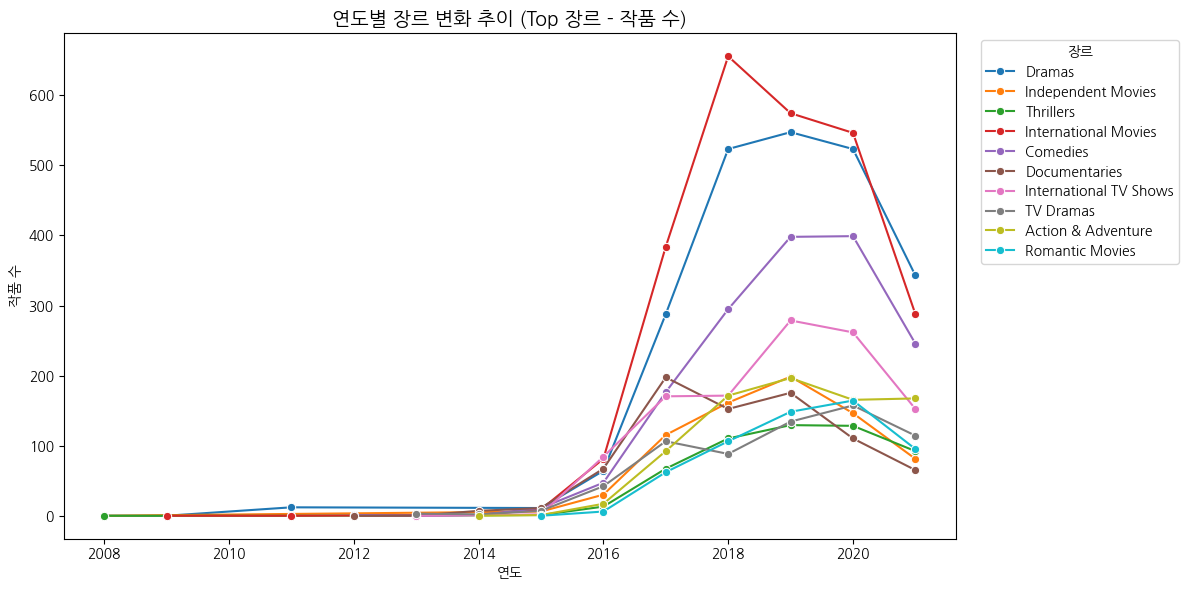

In [116]:
# (A) 절대량: 연도별 장르별 '작품 수' 라인차트
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=trend_year_genre_top,
    x='year_added', y='count',
    hue='genre', marker='o'
)

plt.title('연도별 장르 변화 추이 (Top 장르 - 작품 수)', fontsize=14, fontweight='bold')
plt.xlabel('연도'); plt.ylabel('작품 수')
plt.legend(title='장르', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(); plt.show()

- 2016년 이후 콘텐츠 수가 폭발적으로 늘어남 → 넷플릭스 오리지널 제작/글로벌 확장 시기.

- International Movies, Dramas 같은 장르가 압도적으로 많음.

- 2018년~2019년이 피크, 그 이후 다소 감소 → 코로나 영향, 전략 변화 가능성으로 보임

#11-2.연도별 세부 장르 변화 추이

In [124]:
# 전체 장르 고유값 확인
all_genres = netflix_country_genre['genre'].unique()
all_genres

array(['Documentaries', 'International TV Shows', 'TV Dramas',
       'TV Mysteries', 'Romantic TV Shows', 'TV Comedies', 'Dramas',
       'Independent Movies', 'International Movies', 'British TV Shows',
       'Reality TV', 'Comedies', 'Crime TV Shows',
       'Spanish-Language TV Shows', 'TV Action & Adventure',
       'Romantic Movies', 'Docuseries', 'Horror Movies',
       'Sci-Fi & Fantasy', 'Thrillers', "Kids' TV", 'Action & Adventure',
       'TV Sci-Fi & Fantasy', 'Classic Movies', 'Anime Features',
       'Anime Series', 'Children & Family Movies', 'Music & Musicals',
       'Sports Movies', 'Korean TV Shows', 'Teen TV Shows', 'Cult Movies',
       'Faith & Spirituality', 'LGBTQ Movies', 'TV Horror',
       'Stand-Up Comedy', 'TV Shows', 'Movies', 'Classic & Cult TV',
       'Science & Nature TV', 'TV Thrillers',
       'Stand-Up Comedy & Talk Shows'], dtype=object)

In [125]:
# 세부 리스트
niche_genres = [
    "Stand-Up Comedy",
    "Korean TV Shows",
    "Japanese TV Shows",
    "Spanish-Language TV Shows",
    "Anime Features",
    "Anime Series",
    "Reality TV",
    "Docuseries",
    "Music & Musicals",
    "Faith & Spirituality"
]

trend_year_niche = trend_year_genre_counts[
    trend_year_genre_counts['genre'].isin(niche_genres)
]

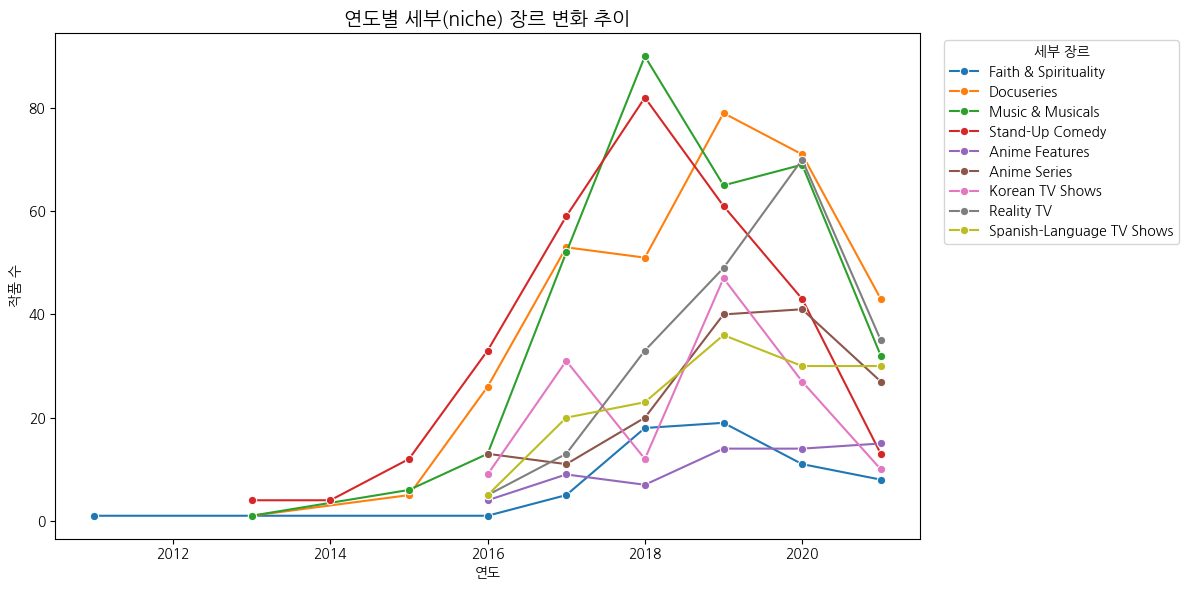

In [126]:
# 시각화
plt.figure(figsize=(12,6))
sns.lineplot(data=trend_year_niche, x='year_added', y='count', hue='genre', marker='o')
plt.title('연도별 세부(niche) 장르 변화 추이', fontsize=14, fontweight='bold')
plt.xlabel('연도'); plt.ylabel('작품 수')
plt.legend(title='세부 장르', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()

- 메인 장르 (드라마, 영화) 외에도 세부 장르가 시기별로 전략적 투자 포인트였음을 확인할 수 있음.

- 특히 Stand-Up Comedy (2015 - 2018), Docuseries(2016- 2020), Korean TV Shows (2018~) 같은 장르의 급성장은 넷플릭스가 시장 수요와 글로벌 전략에 따라 빠르게 대응했음을 보여줌.

#12.워드클라우드

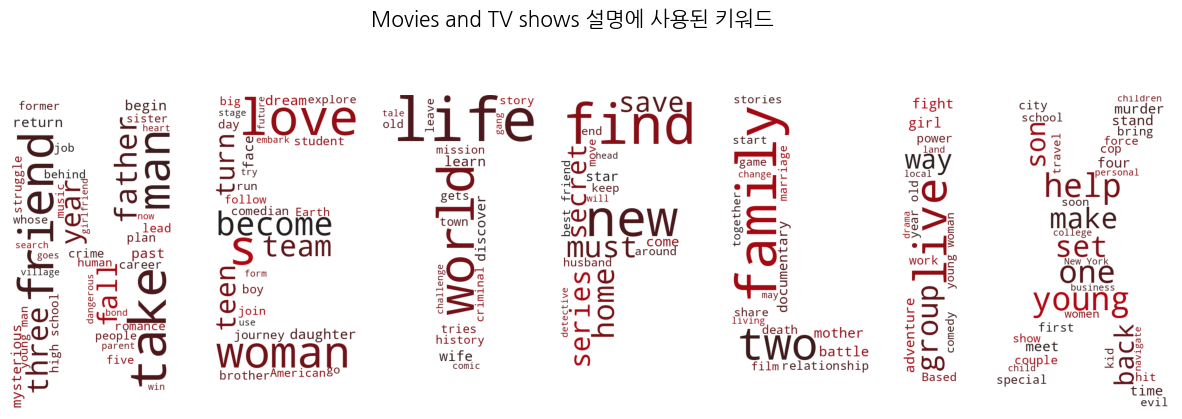

In [88]:
from wordcloud import WordCloud
from PIL import Image

plt.figure(figsize=(15, 5))

text = str(list(netflix['description']))
mask = np.array(Image.open('/content/drive/MyDrive/분석/netflix/netflix_logo.jpg'))
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

wordcloud = WordCloud(background_color = 'white', width = 1400,  height = 1400, max_words = 170, mask = mask, colormap=cmap).generate(text)

plt.suptitle('Movies and TV shows 설명에 사용된 키워드', fontweight='bold', fontsize=15)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

넷플릭스의 줄거리 설명에서 가장 자주 등장하는 키워드는 family, life, love

넷플릭스 콘텐츠가 전 세계적으로 공감할 수 있는 보편적 주제를 중심으로 구성됨을 보여준다.

#13.추천 시스템

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [169]:
#1. 텍스트 데이터 준비

# 결측치 채우기
netflix['description'] = netflix['description'].fillna('')
netflix['listed_in']   = netflix['listed_in'].fillna('')

# "장르 + 설명"을 하나의 텍스트로 합치기
## 장르의 중요도를 조금 높여주고 싶어서 *2로 가중치 부여함
netflix['text'] = (
    netflix['listed_in'].str.replace(',', ' ', regex=False).str.lower() + ' ' +
    netflix['listed_in'].str.replace(',', ' ', regex=False).str.lower() + ' ' +   # 장르 가중치 (x2)
    netflix['description'].str.lower()
)

In [170]:
#2. TF-IDF 벡터화

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,                 # 너무 희귀한 단어 제거
    stop_words='english'
)
tfidf = vectorizer.fit_transform(netflix['text'])

TF-IDF 벡터화
- 각 단어가 문서(=영화 설명/장르)에서 얼마나 중요한지를 수치화하는 작업
- 영어 중심 데이터 -> stop_words='english' 사용
- "game" 같은 흔한 단어는 점수 ↓, "squid" 같은 특정 단어는 점수 ↑.

    결과 → 각 영화/드라마가 고차원 벡터로 표현됨.

In [171]:
#3. 유사도(코사인) 계산을 빠르게 하기 위해 linear_kernel 사용함
## (TF-IDF는 L2 정규화가 되어 있으므로 dot product == cosine similarity)

cosine_sim = linear_kernel(tfidf, tfidf)

유사도(코사인)
- 두 벡터(=두 영화의 텍스트 표현)가 얼마나 비슷한 방향을 가리키는지 측정.
- 1에 가까울수록 매우 비슷 / 0이면 무관, -1이면 정반대.
- 추천 시스템에서 "비슷한 콘텐츠 찾기"의 기본 도구.

In [172]:
#4. 타이틀 인덱스 맵핑 (빠른 검색용)
## 중복 타이틀이 있을 수 있으니, 같은 이름이면 여러 index를 보관

title_to_indices = {}
for i, title in enumerate(netflix['title'].fillna('')):
    key = title.strip().lower()
    if key not in title_to_indices:
        title_to_indices[key] = []
    title_to_indices[key].append(i)

In [173]:
#5. 추천 함수

## (1) 선택적으로 타입/국가/연도 필터링

def _post_filter(df, content_type=None, country=None, year_from=None, year_to=None):

  out = df.copy()

  if content_type:
    out = out[out['type'].str.lower() == content_type.lower()]
  if country:
    out = out[out['country'].fillna('').str.contains(country, case=False, na=False)]
  if year_from is not None:
    out = out[out['year_added'] >= year_from]
  if year_to is not None:
      out = out[out['year_added'] <= year_to]
  return out

In [177]:
## (2) 타이틀로 비슷한 작품 추천

def recommend_by_title(title, top_n=10, content_type=None, country=None, year_from=None, year_to=None):

    key = title.strip().lower()

    # 1) 정확히 같은 타이틀 먼저 찾기
    idx_list = title_to_indices.get(key, [])

    # 2) 없으면 부분일치로 검색해서 가장 긴 일치 타이틀을 선택
    if not idx_list:
        candidates = netflix[netflix['title'].str.contains(title, case=False, na=False)]
        if candidates.empty:
            print(f"[경고] '{title}'(와)과 일치하는 타이틀을 찾지 못했습니다.")
            return pd.DataFrame()
        idx_list = [candidates.index[0]]

    # 여러 개면 첫 번째만 기준으로 사용 (원하면 top-k 평균 유사도 등으로 확장 가능)
    idx = idx_list[0]

    # 3) 유사도 점수 내림차순 정렬
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 4) 자기 자신 제외하고 상위 N 추출
    ranked = [i for i, s in sim_scores if i != idx]

    # 5) 필터링 적용
    candidates_df = netflix.iloc[ranked][['title', 'type', 'country', 'listed_in', 'year_added', 'description']].copy()
    candidates_df = _post_filter(candidates_df, content_type, country, year_from, year_to)

    return candidates_df.head(top_n)

In [188]:
## (3) 자유 텍스트로 비슷한 작품 추천 (타이틀 모를 때)

def recommend_by_query(query_text, top_n=10, content_type=None, country=None, year_from=None, year_to=None):

    q = query_text.lower()
    q_vec = vectorizer.transform([q])                # (1, V)
    scores = linear_kernel(q_vec, tfidf).ravel()     # (N, )

    ranked_idx = np.argsort(-scores)                 # 내림차순
    candidates_df = netflix.iloc[ranked_idx][['title', 'type', 'country', 'listed_in', 'year_added', 'description']].copy()
    candidates_df = _post_filter(candidates_df, content_type, country, year_from, year_to)

    return candidates_df.head(top_n)

---------------------------------------------------------------------

In [191]:
# 실행해보기

# 1) 그냥 비슷한 작품 7개 추천
recommend_by_title("Squid Game", 7)

,title,type,country,listed_in,year_added,description
3684,Kakegurui,TV Show,No Data,"International TV Shows, TV Dramas, TV Thrillers",2019,Yumeko Jabami enrolls at Hyakkaou Private Acad...
5027,Marseille,TV Show,France,"International TV Shows, TV Dramas, TV Thrillers",2018,The longtime mayor of Marseille is preparing t...
3590,Til Death Do Us Part,TV Show,Taiwan,"International TV Shows, TV Dramas, TV Thrillers",2019,Based on the speculative short stories of Mirr...
1554,Children of Adam,TV Show,Lebanon,"International TV Shows, TV Dramas, TV Thrillers",2020,"Amid crime and corruption, the lives of two co..."
6873,Gonul,TV Show,Turkey,"International TV Shows, TV Dramas, TV Thrillers",2017,A nurse escapes from her surgeon fiancé after ...
1373,50M2,TV Show,Turkey,"International TV Shows, TV Dramas, TV Thrillers",2021,"Seeking to uncover the truth about his past, a..."
3082,Occupied,TV Show,"Norway, Sweden","International TV Shows, TV Dramas, TV Thrillers",2019,"In the near future, Russia initiates a ""silk g..."


In [193]:
# 2) 한국 콘텐츠만 추천
recommend_by_title("Squid Game",3, country="South Korea")

,title,type,country,listed_in,year_added,description
1955,The School Nurse Files,TV Show,South Korea,"International TV Shows, TV Dramas, TV Mysteries",2020,Wielding a light-up sword through the dark cor...
8117,Suits,TV Show,South Korea,"International TV Shows, Korean TV Shows, TV Co...",2019,A renowned corporate attorney at a prestigious...
5349,Entangled,TV Show,South Korea,"International TV Shows, TV Dramas",2017,When the children of two families become frien...


In [194]:
# 3) 타이틀 + 타입 필터 (영화만)
recommend_by_title("Squid Game",3 , content_type="Movie")

,title,type,country,listed_in,year_added,description
6623,Domino,Movie,"Denmark, France, Belgium, Italy, Netherlands, ...","International Movies, Thrillers",2019,A Copenhagen police officer hunts for the man ...
2914,Isi & Ossi,Movie,Germany,"Comedies, International Movies, Romantic Movies",2020,A billionaire's daughter fakes a relationship ...
5903,Creep,Movie,United States,"Horror Movies, Independent Movies, Thrillers",2015,When a cash-strapped videographer takes a job ...


In [196]:
# 4) 자유 텍스트로 비슷한 작품 추천
recommend_by_query("korean survival thriller",5 , content_type="TV Show")

,title,type,country,listed_in,year_added,description
3083,Pucca: Love Recipe,TV Show,No Data,"Kids' TV, Korean TV Shows",2019,Faced with a threat to the survival of her fam...
3928,Persona,TV Show,South Korea,"International TV Shows, Korean TV Shows, TV Dr...",2019,An exploration of different personas in an ecl...
8347,The Homecoming,TV Show,No Data,"International TV Shows, Korean TV Shows, Reali...",2017,"Panelists from the Korean show ""Abnormal Summi..."
3462,Chicago Typewriter,TV Show,South Korea,"International TV Shows, Korean TV Shows, Roman...",2019,A veterinarian and two writers have a mysterio...
3129,Crash Landing on You,TV Show,South Korea,"International TV Shows, Korean TV Shows, Roman...",2019,A paragliding mishap drops a South Korean heir...
